## 範例重點
* 學習如何在 keras 中加入自定義的 callbacks
* 知道 callback function 可以動作的時機

In [27]:
import os
import keras
import numpy as np

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [23]:
"""
# 載入 Callbacks，撰寫一個 f1 score 的 callback function
"""

from keras.callbacks import Callback
from sklearn.metrics import f1_score

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [18]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_f1sc]
         )



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512 

Epoch 46/50
50000/50000 [==============================] - 19s 374us/step - loss: 0.5643 - accuracy: 0.8350 - val_loss: 1.6149 - val_accuracy: 0.4875
Epoch 47/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.5493 - accuracy: 0.8409 - val_loss: 1.6057 - val_accuracy: 0.4928
Epoch 48/50
50000/50000 [==============================] - 18s 354us/step - loss: 0.5294 - accuracy: 0.8480 - val_loss: 1.6008 - val_accuracy: 0.4950
Epoch 49/50
50000/50000 [==============================] - 31s 627us/step - loss: 0.5147 - accuracy: 0.8537 - val_loss: 1.6448 - val_accuracy: 0.4861
Epoch 50/50
50000/50000 [==============================] - 27s 540us/step - loss: 0.4984 - accuracy: 0.8615 - val_loss: 1.6661 - val_accuracy: 0.4842


In [19]:
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# 在訓練後，將 f1sc 紀錄調出
valid_f1sc = model.history.history['val_f1sc']

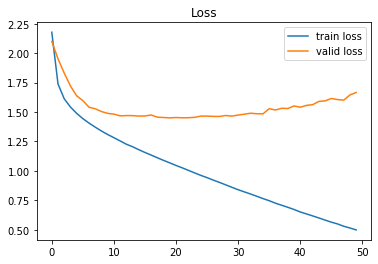

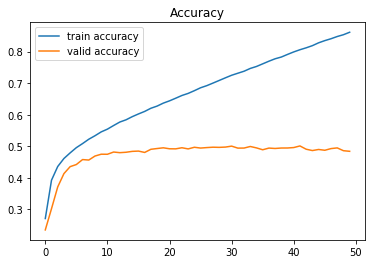

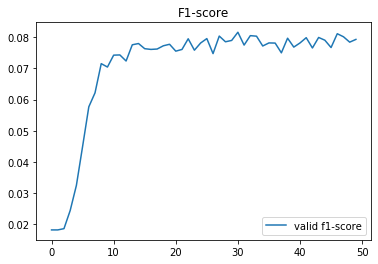

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()


## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [30]:

class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def on_train_begin(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
#         y_pred = np.round(np.asarray(self.model.predict(self.validation_data[0])))
#        y_pred = list (map(boolMap,self.model.predict([self.validation_data[0],self.validation_data[1]])))
        x_test = self.validation_data[0]
        y_test = np.round(self.validation_data[1].argmax(axis = 1))
        print(x_test.shape)
        print(y_test.shape)
        y_pred = np.round(self.model.predict(x_test).argmax(axis = 1))
        print(y_pred.shape)
        #cm = confusion_matrix(np.round(y_test), np.round(y_pred))
        #print(cm)
        
        logs["val_tp"] = np.sum(np.logical_and(y_pred == 1, y_test == 1))
        logs["val_tn"] = np.sum(np.logical_and(y_pred == 0, y_test == 0))
        
#         logs["valid_tp"] = confusion_matrix[0.0]
#         logs["valid_tn"] = confusion_matrix[1.1]

        
rec_tptn = Record_tp_tn()

In [ ]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )



Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_24 (Batc (None, 128)               512 

50000/50000 [==============================] - 12s 240us/step - loss: 0.7097 - accuracy: 0.7775 - val_loss: 1.5355 - val_accuracy: 0.4976
(10000, 3072)
(10000,)
(10000,)
Epoch 39/50
50000/50000 [==============================] - 11s 222us/step - loss: 0.6906 - accuracy: 0.7847 - val_loss: 1.5320 - val_accuracy: 0.4994
(10000, 3072)
(10000,)
(10000,)
Epoch 40/50
50000/50000 [==============================] - 11s 228us/step - loss: 0.6729 - accuracy: 0.7928 - val_loss: 1.5382 - val_accuracy: 0.4995
(10000, 3072)
(10000,)
(10000,)
Epoch 41/50
50000/50000 [==============================] - 11s 220us/step - loss: 0.6563 - accuracy: 0.7985 - val_loss: 1.5456 - val_accuracy: 0.4993
(10000, 3072)
(10000,)
(10000,)
Epoch 42/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.6363 - accuracy: 0.8068 - val_loss: 1.5603 - val_accuracy: 0.5010
(10000, 3072)
(10000,)
(10000,)
Epoch 43/50
50000/50000 [==============================] - 14s 287us/step - loss: 0.6189 - accuracy: 0

In [ ]:
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()



valid_all = np.array(valid_tp)+np.array(valid_tn)

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.plot(range(len(valid_all)), valid_all, label="all", color="g")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()